In [32]:
# Copied from https://github.com/jeancroy/RP-fit

import numpy as np
import pandas as pd
import seaborn as sns

import requests
from io import StringIO, BytesIO
from os import path

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)



In [33]:
def download_sheet(file_id, sheet_id):
    r = requests.get(f'https://docs.google.com/spreadsheets/d/{file_id}/export?format=csv&id={file_id}&gid={sheet_id}')
    df = pd.read_csv(BytesIO(r.content), thousands=',')
    return df


In [34]:
refresh_rp_file = True

rp_file_id = "1kBrPl0pdAO8gjOf_NrTgAPseFtqQA27fdfEbMBBeAhs"

sheet_ids = {
    "data_1_9": "1682088244",
    "data_10_29": "1691041080",
}

local_files = {
    "data": './data/rp-data.pickle',
    "natures": './data/natures.pickle',
    "subskills": './data/subskills.pickle',
    "mainskills": './data/mainskills.pickle',
    "pokedex": './data/pokedex.pickle',
}

if refresh_rp_file:
    data_1_9 = download_sheet(rp_file_id, sheet_ids["data_1_9"])
    data_10_29 = download_sheet(rp_file_id, sheet_ids["data_10_29"])

    data = pd.concat([data_1_9, data_10_29], axis=0)
    data = data.dropna(subset=["Pokemon", "Level", "RP", "Nature", "MS lvl"])
    data = data.fillna({'Amnt': 0, 'Ing2P': 0, 'Help skill bonus': 1, 'RP Multiplier': 1, 'ModelRP': -1, 'Difference': -1})
    data = data.fillna({'Sub Skill 1': '', 'Sub Skill 2': '', 'Ingredient 2': '', 'Source': ''})

    # avoid second food item
    data = data[data["Level"] < 30]

    # avoid a bug in RP of freshly caught mon with skill up unlocked.
    data = data[~((data["Sub Skill 1"] == "Skill Level Up S") & (data["MS lvl"] == 2) & (data["Level"] > 9))]
    data = data[~((data["Sub Skill 1"] == "Skill Level Up M") & (data["MS lvl"] == 3) & (data["Level"] > 9))]

    data.to_pickle(local_files["data"])

else:
    data = pd.read_pickle(local_files["data"])

natures = pd.read_pickle(local_files["natures"])
mainskills = pd.read_pickle(local_files["mainskills"])
subskills = pd.read_pickle(local_files["subskills"])
pokedex = pd.read_pickle(local_files["pokedex"])



In [35]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5173.000000,5084.000000,5173.000000,5173.000000,5173.000000,5173.0,5173.0,5173.0,5173.000000,5173.000000
mean,9.418133,556.249758,1.397062,323.840727,-0.097993,3994.181326,3860.132763,12.023197,27.991688,36.443650,108.762420,0.999196,0.989426,0.995206,1.000541,1.005993,0.155873,19.187500,52.919196,145.305045,1.0,0.0,0.0,0.989337,1.025361
std,6.230190,322.910829,0.895382,220.694561,0.843832,938.700750,999.883325,3.317360,2.617562,6.866459,15.689619,0.291232,0.059363,0.045315,0.118052,0.118327,0.093160,21.148913,25.013470,54.571180,0.0,0.0,0.0,0.035067,0.066437
min,1.000000,245.000000,1.000000,-1.000000,-4.360000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.000000,0.000000,25.000000,90.000000,1.0,0.0,0.0,0.790000,1.000000
25%,5.000000,349.000000,1.000000,266.090000,-0.750000,3400.000000,3079.788000,10.000000,26.000000,32.000000,98.000000,0.800000,1.000000,1.000000,1.000000,1.000000,0.130000,5.990000,35.000000,101.000000,1.0,0.0,0.0,1.000000,1.000000
50%,8.000000,435.000000,1.000000,350.680000,-0.090000,4000.000000,3853.200000,11.000000,28.000000,35.000000,103.000000,0.930000,1.000000,1.000000,1.000000,1.000000,0.190000,12.790000,43.000000,121.000000,1.0,0.0,0.0,1.000000,1.000000
75%,12.000000,661.000000,1.000000,441.240000,0.270000,4500.000000,4473.000000,14.000000,30.000000,40.000000,115.000000,1.160000,1.000000,1.000000,1.000000,1.000000,0.220000,24.740000,66.000000,200.000000,1.0,0.0,0.0,1.000000,1.000000
max,29.000000,3432.000000,6.000000,1774.300000,9.040000,6300.000000,6916.140000,23.000000,35.000000,67.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.370000,294.950000,195.000000,302.000000,1.0,0.0,0.0,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,8.0,531.0,Hardy,1,Questions help guides,530.90,-0.10,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.25,23.08,531.00,ArbokNeutral81,78.0,103,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,9.0,574.0,Naughty,1,Rate My Mon,574.43,0.43,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.25,23.08,538.67,ArbokNeutral91,80.0,103,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1,Questions help guides,538.03,0.03,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.25,23.08,530.88,ArbokNeutral81,78.0,103,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3,,-1.00,-1.00,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,NaN,0.00,1060.38,ArcanineSklNtr53,31.0,130,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2,pokemon sleep general,-1.00,-1.00,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,NaN,0.00,662.04,ArcanineNtrSkl32,29.0,130,1,True,,,,0.0,0.0,1.0,1.0


In [36]:
# nature and subskill with known effects on production

nature_soh_effect = 0.1
subskill_help_s_effect = 0.07
subskill_help_m_effect = 0.14

subskill_ing_s_effect = 0.18
subskill_ing_m_effect = 0.36

subskill_trigger_s_effect = 0.18
subskill_trigger_m_effect = 0.36

In [37]:
# All the formula "ifs" will be implemented as one-hot vector  (0,1)

# Specialty (Class)

classes = ["Ingredients", "Berries", "Skills"]
data_has_class = dict([(c, (data["Class"] == c).astype(int).to_numpy()) for c in classes])

# Natures

traits = natures["TraitPos"].unique()

natures_with_positive_trait = dict([(t, natures[natures["TraitPos"] == t]["Nature"].tolist()) for t in traits])
natures_with_negative_trait = dict([(t, natures[natures["TraitNeg"] == t]["Nature"].tolist()) for t in traits])

data_has_positive_trait = dict(
    [(t, data["Nature"].isin(natures_with_positive_trait[t]).astype(int).to_numpy()) for t in traits])
data_has_negative_trait = dict(
    [(t, data["Nature"].isin(natures_with_negative_trait[t]).astype(int).to_numpy()) for t in traits])

# Subskills

subs = subskills["Subskill"].unique()

data_has_subskill = dict([(s,
                           (((data["Sub Skill 1"] == s) & (data["Level"] >= 10)) |
                            ((data["Sub Skill 2"] == s) & (data["Level"] >= 25))
                            ).astype(int).to_numpy()
                           )
                          for s in subs
                          ])

In [38]:
# Here we start to organise the globals variables so writing the model get less confusing.

from types import SimpleNamespace

computed = SimpleNamespace()

computed.has_class = data_has_class
computed.has_positive_trait = data_has_positive_trait
computed.has_negative_trait = data_has_negative_trait
computed.has_subskill = data_has_subskill

# We could redo that work but it's not related to the optimisation
computed.ing1_power_base = data["Ing1P"]
computed.berry_power_base = data["Berry1"]
computed.berry_power_at_level = data["BerryL"]

In [39]:
# Here we will reproduce the Help/hr information as a test of using those one-hot vectors.

data_period_base = data["Freq1"]
data_period_level = data_period_base * ((501 - data["Level"]) / 500.0)

nature_correction = (
        1
        - (computed.has_positive_trait[
               "Speed of Help"] * nature_soh_effect)  # Speed is the only nature where positive is a substraction
        + (computed.has_negative_trait["Speed of Help"] * nature_soh_effect)  # Because we work on time between helps.
)

subskill_correction = (
        1
        - (computed.has_subskill["Helping Speed S"] * subskill_help_s_effect)
        - (computed.has_subskill["Helping Speed M"] * subskill_help_m_effect)
)

data_period_level_nature_subskill = data_period_level * nature_correction * subskill_correction

# Are we the same up to csv precision ? Yes
#(data_period_level_nature_subskill - data["FreqL"]).describe()

# Are we exactly the same ? Yes
data_helps_per_hour = np.floor(100 * 3600 / data_period_level_nature_subskill) / 100
(data_helps_per_hour - data["Helps per hour"]).describe()

# Save to computed
computed.period_base = data_period_base
computed.period_level = data_period_level
computed.helps_per_hour = data_helps_per_hour


count    5173.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

In [40]:
# Here we build the initial guess
# And package it into the 1-D array that the optimizer require.
# While doing, so we'll build a map between the model dict and the 1-D array otherwise it'll get confusing fast.

initial = {
    'Nature Ingredient Finding': 0.2,  # Idea: We start at 0.25 because it's about midpoint between 0.18 and  0.36
    'Nature Main Skill Chance': 0.2,  # If it still goes to 0.2 it is what it is.
    'Nature Energy Recovery': 0.08,
}


In [41]:
# Initial guess for the ing% and skillProduct ( skill% * skillValue ) 

pokemon_to_position = {}
guess_ing_fractions = []
guess_skl_products = []

previous_ing_fractions = []
previous_skl_products = []

for record in pokedex.to_dict(orient='records'):

    pokemon_to_position[record["Pokemon"]] = len(guess_ing_fractions)

    # Simple linear model
    guess_ing_fractions.append((record["Berry Power"] - 7) / record["Ing 1 Power"])
    guess_skl_products.append(0.5 * (record["Berry Power"] - 3) * (3.5 if record["Class"] == "Skills" else 1.0))

    # Last fit (reproduce result)
    previous_ing_fractions.append(record["Last fit ing"])
    previous_skl_products.append(record["Last fit skl"])

#initial["Pokemons ing fractions"] = guess_ing_fractions
#initial["Pokemons skill products"] = guess_skl_products

initial["Pokemons ing fractions"] = previous_ing_fractions
initial["Pokemons skill products"] = previous_skl_products

# In the final vector there would be offset
# But the pack/unpack idea is good enough to avoid those.
data_pokemon_positions = np.array(list(map(lambda x: pokemon_to_position[x], data["Pokemon"])))

computed.ing_positions = data_pokemon_positions
computed.skl_positions = data_pokemon_positions


In [42]:
# Intial guess for skill growth
# We assume that the conversion from level 1 to level L
# Has the shape a*exp(b*L). Initial guess for a,b fitted on charge strength 

for record in mainskills.to_dict(orient='records'):
    skillname = record["Skill"]
    initial[skillname] = [0.7462, 0.3224]


In [43]:
# Initial guess for ingredient growth.
# Comes from a previous fit
# Numpy poly convention is highest degree first

initial["Ing Growth Poly"] = [0.000224436802535453, 0.00266425197402284, 0.004768806303]

In [44]:
# Add our guess for the sub skills that multiply the whole rp

bonus = subskills[subskills["RP Multiplier Guess"] > 0]
computed.bonus_subskill_name = bonus["Subskill"].tolist()

for record in bonus.to_dict(orient='records'):
    initial[record["Subskill"]] = record["RP Multiplier Guess"]

In [45]:
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

import numbers


def pack(source):

    x = []
    unpack_info = {}

    for k, v in source.items():

        start = len(x)

        if isinstance(v, list) and len(v) > 0:
            x.extend(v)
            unpack_info[k] = (start, len(v))

        elif isinstance(v, numbers.Number):
            x.append(v)
            unpack_info[k] = (start, 0)

    return np.array(x), unpack_info


def unpack(x, unpack_info):

    unpacked = {}

    for k, v in unpack_info.items():

        start, length = v

        if (length == 0):
            unpacked[k] = x[start]
        else:
            unpacked[k] = np.array(x[start:start + length])

    return unpacked


x0, unpack_info = pack(initial)
computed.unpack_info = unpack_info

In [46]:
# We compute our RP model here

def get_model(variables):

    model = SimpleNamespace()
    model.data = data
    model.computed = computed
    model.vars = unpack(variables, computed.unpack_info)
    return model


def ing1_value_at_level(model):
    return model.computed.ing1_power_base * (1.0 + np.polyval(model.vars["Ing Growth Poly"], model.data["Level"]))


def ber_value_at_level(model):
    return model.computed.berry_power_at_level


def ing1_amount(model):
    return 1.0 + model.computed.has_class["Ingredients"]


def ber_amount(model):
    return 1.0 + model.computed.has_class["Berries"] + model.computed.has_subskill["Berry Finding S"]


def ing_fraction(model):

    return model.vars["Pokemons ing fractions"].take(model.computed.ing_positions)


def skl_product(model):

    return model.vars["Pokemons skill products"].take(model.computed.skl_positions)


def skl_growth(model):

    a = model.data["MSkill"].map(lambda x: model.vars[x][0])
    b = model.data["MSkill"].map(lambda x: model.vars[x][1])

    growth = a * np.exp(b * model.data["MS lvl"])
    growth[model.data["MS lvl"] == 1] = 1.0

    return growth


def ing_modifier(model):

    nature_ing_effect = model.vars["Nature Ingredient Finding"]

    nature_correction = (
            1.0
            + (model.computed.has_positive_trait["Ingredient Finding"] * nature_ing_effect)
            - (model.computed.has_negative_trait["Ingredient Finding"] * nature_ing_effect)
    )

    subskill_correction = (
            1.0
            + (model.computed.has_subskill["Ingredient Finder S"] * subskill_ing_s_effect)
            + (model.computed.has_subskill["Ingredient Finder M"] * subskill_ing_m_effect)
    )

    return nature_correction * subskill_correction


def skl_modifier(model):

    nature_msc_effect = model.vars["Nature Main Skill Chance"]

    nature_correction = (
            1.0
            + (model.computed.has_positive_trait["Main Skill Chance"] * nature_msc_effect)
            - (model.computed.has_negative_trait["Main Skill Chance"] * nature_msc_effect)
    )

    subskill_correction = (
            1.0
            + (model.computed.has_subskill["Skill Trigger S"] * subskill_trigger_s_effect)
            + (model.computed.has_subskill["Skill Trigger M"] * subskill_trigger_m_effect)
    )

    return nature_correction * subskill_correction


def energy_modifier(model):

    nature_energy_effect = model.vars["Nature Energy Recovery"]

    return (
            1.0
            + (model.computed.has_positive_trait["Energy Recovery"] * nature_energy_effect)
            - (model.computed.has_negative_trait["Energy Recovery"] * nature_energy_effect)
    )


def fractional_help_count(model):
    return 5.0 * model.computed.helps_per_hour


def bonus_subskill(model):

    bonus = 1.0

    for name in computed.bonus_subskill_name:
        bonus += model.computed.has_subskill[name] * model.vars[name]

    return bonus


def RP(variables):

    model = get_model(variables)

    ing = ing_fraction(model) * ing_modifier(model)

    ingredients_value = ing * ing1_amount(model) * ing1_value_at_level(model)

    berries_value = (1.0 - ing) * ber_amount(model) * ber_value_at_level(model)

    mainskill_value = skl_product(model) * skl_modifier(model) * skl_growth(model)

    help_count = fractional_help_count(model)

    energy_correction = energy_modifier(model)

    bonus = bonus_subskill(model)

    rp = bonus * help_count * energy_correction * (ingredients_value + berries_value + mainskill_value)

    return rp


def residual(variables):

    return data["RP"].to_numpy() - RP(variables)



In [47]:
# Can we reproduce the sheet prediction ?
# Yes. They have a small difference in how they do skl growth.

df = data[["Pokemon", "ID", "RP", "ModelRP"]].copy()
df["RP2"] = RP(x0)
df = df[df["ModelRP"] > 0]
df[np.abs(df["RP2"] - df["ModelRP"]) > 0.5]

,Pokemon,ID,RP,ModelRP,RP2
1797,Eevee,EeveeSassy105Skill Level Up M,1320.0,1320.14,1320.752418
1831,Eevee,EeveeSassy115Skill Level Up M,1325.0,1324.83,1325.442162
2375,Sudowoodo,SudowoodoAdamant126Skill Level Up M,1777.0,1774.30,1775.640848
2379,Sudowoodo,SudowoodoHasty255Skill Level Up MHelping Speed M,1419.0,1419.96,1420.574255
2385,Sudowoodo,SudowoodoBold165Skill Level Up M,1241.0,1241.34,1241.890591


In [48]:
r = np.abs(residual(x0))
pd.Series(r).describe()

count    5173.000000
mean       13.478749
std        50.307050
min         0.000018
25%         0.175193
50%         0.364530
75%         2.046479
max      1650.264122
dtype: float64

C:\Users\RaenonX\Documents\Projects\PokemonSleep\pokemon-sleep-scraper\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RaenonX\Documents\Projects\PokemonSleep\pokemon-sleep-scraper\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

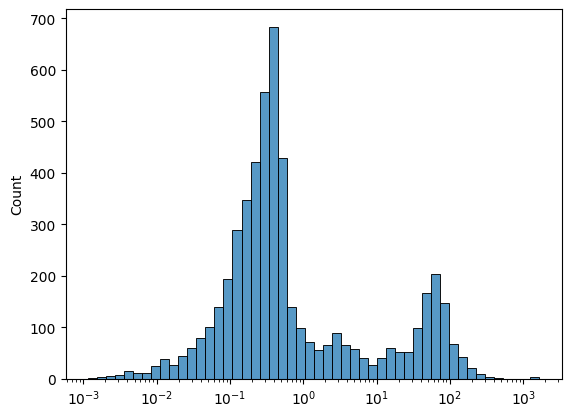

In [49]:
sns.histplot(x=r[r > 1e-3], log_scale=True)

In [50]:
import scipy

opt = scipy.optimize.least_squares(residual, x0, loss="soft_l1", xtol=None)
print(opt)

C:\Users\RaenonX\Documents\Projects\PokemonSleep\pokemon-sleep-scraper\venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 2.379e-01 -4.726e-01 ... -7.326e-01  3.287e-01]
           x: [ 2.000e-01  1.999e-01 ...  2.196e-01  2.194e-01]
        cost: 1657.612604170366
         jac: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [ 0.000e+00  1.068e+02 ...  0.000e+00  0.000e+00]
               ...
               [ 5.616e+01 -1.458e+03 ...  0.000e+00  0.000e+00]
               [ 0.000e+00 -6.919e+02 ...  0.000e+00  0.000e+00]]
        grad: [ 6.016e-02  9.700e-02 ...  1.946e-04  9.482e-05]
  optimality: 68.99961145992627
 active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
        nfev: 255
        njev: 208


In [51]:
np.save("./results/linear-fit", opt.x)

count    5.173000e+03
mean     5.717382e-01
std      5.094797e+00
min      3.128662e-10
25%      1.301459e-01
50%      2.664895e-01
75%      4.160563e-01
max      1.937684e+02
dtype: float64

C:\Users\RaenonX\Documents\Projects\PokemonSleep\pokemon-sleep-scraper\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RaenonX\Documents\Projects\PokemonSleep\pokemon-sleep-scraper\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

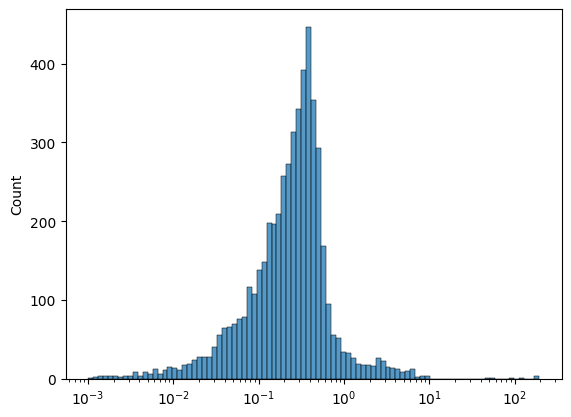

In [52]:
r_opt = np.abs(residual(opt.x))
pd.Series(r_opt).describe()
sns.histplot(x=r_opt[r_opt > 1e-3], log_scale=True)

In [53]:
sol = unpack(opt.x, unpack_info)

# Print the part of solution dictionary that have small size
sol2 = sol.copy()
del sol2["Pokemons ing fractions"]
del sol2["Pokemons skill products"]

pprint(sol2)

{'Nature Ingredient Finding': 0.19997015353262865,
 'Nature Main Skill Chance': 0.1998531722501436,
 'Nature Energy Recovery': 0.08008353385270557,
 'Charge Strength S': array([0.74783691, 0.32191783]),
 'Charge Strength M': array([0.74491663, 0.32274732]),
 'Ingredient Magnet S': array([0.74546215, 0.32268629]),
 'Cooking Power-Up S': array([0.74533295, 0.32258811]),
 'Extra Helpful S': array([0.7452349 , 0.32267238]),
 'Charge Energy S': array([0.74755515, 0.3219095 ]),
 'Energizing Cheer S': array([0.73290614, 0.33239573]),
 'Energy for Everyone S': array([0.74573292, 0.32266353]),
 'Dream Shard Magnet S': array([0.7467496 , 0.32209574]),
 'Metronome': array([0.74486602, 0.32309079]),
 'Ing Growth Poly': array([ 0.00018915,  0.00307468, -0.00194419]),
 'Dream Shard Bonus': 0.2193142402257843,
 'Energy Recovery Bonus': 0.2191226850036324,
 'Helping bonus': 0.21896523337450344,
 'Inventory Up S': 0.06922661169315115,
 'Inventory Up M': 0.13054707900820658,
 'Inventory Up L': 0.1794780

In [57]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({
    "Pokemon": pokedex["Pokemon"], "ing%": sol["Pokemons ing fractions"] * 100.0,
    "skill% * skillValue": sol["Pokemons skill products"]
})
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.631496,16.738749
Ivysaur,25.472374,16.705482
Venusaur,26.598309,18.432887
Charmander,20.051566,9.680406
Charmeleon,22.676435,14.058477
Charizard,22.435554,14.006957
Squirtle,27.011999,17.630695
Wartortle,27.072603,17.581066
Blastoise,27.468070,18.442810


In [60]:
res.to_json("./../../transformed/ingredient_split.json", orient="records")

In [55]:
growth_display = {}
growth_display["Level"] = list(range(2, 7))

for record in mainskills.to_dict(orient='records'):

    skillname = record["Skill"]
    params = sol[skillname]
    values = []

    for level in range(2, 7):
        values.append(params[0] * np.exp(params[1] * level))

    growth_display[skillname] = values

df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.423709,1.420504,1.421371,1.420845,1.420898,1.423149,1.424832,1.421822,1.422145,1.421383
3,1.964393,1.961597,1.962674,1.961756,1.961994,1.963604,1.986649,1.963253,1.962584,1.963486
4,2.710413,2.708802,2.710124,2.708590,2.709147,2.709301,2.769994,2.710861,2.708399,2.712341
5,3.739750,3.740628,3.742226,3.739741,3.740825,3.738185,3.862216,3.743159,3.737636,3.746803
6,5.160000,5.165495,5.167385,5.163447,5.165379,5.157798,5.385105,5.168557,5.158001,5.175799


In [56]:
df = data[["Pokemon", "ID", "NatureP", "NatureN", "Sub Skill 1", "Sub Skill 2", "RP"]].copy()

df["fit"] = RP(opt.x)
df["error2"] = residual(opt.x) ** 2

df = df.sort_values("error2", ascending=False)
df.head(100)

,Pokemon,ID,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error2
983,Raichu,RaichuNaughty151Ingredient Finder S,Speed of Help,Main Skill Chance,Ingredient Finder S,,680.0,873.768398,37546.192122
2150,Sableye,SableyeBrave61,Speed of Help,EXP Gains,,,390.0,571.237588,32847.063256
2152,Sableye,SableyeRelaxed41,Energy Recovery,EXP Gains,,,361.0,540.579262,32248.711276
2151,Sableye,SableyeRash61,Ingredient Finding,Main Skill Chance,,,348.0,469.135852,14673.894749
2607,Togetic,TogeticQuiet51,Ingredient Finding,Exp Gains,,,556.0,457.398248,9722.305504
2034,Golem,GolemMild262Skill Trigger SSkill Level Up S,Ingredient Finding,Energy Recovery,Skill Trigger S,Skill Level Up S,801.0,859.011732,3365.360996
555,Ivysaur,IvysaurNeutral141Helping Speed M,-,-,Helping Speed M,,723.0,677.488620,2071.285723
1715,Charizard,CharizardMild276Helping Speed MSkill Level Up M,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1504.275117,94.573341
1029,Sableye,SableyeBrave191Ingredient Finder S,Speed of Help,EXP Gains,Ingredient Finder S,,681.0,671.286299,94.355978
1102,Togekiss,TogekissGentle103Skill Trigger M,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1272.631132,87.775687
